#### Crime Data Analysis - Aatreyi Dutt (24070243059)

In [1]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt

##### Imports

geodataframe (shp)

In [2]:
gdf = gpd.read_file("C:/Users/HOME/OneDrive/Desktop/SIG/GA/2011_crime/2011_Dist.shp")

In [3]:
gdf.columns

Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')

In [4]:
gdf.ST_NM.unique()

array(['Andhra Pradesh', 'Uttar Pradesh', 'Gujarat', 'Maharashtra',
       'Mizoram', 'Rajasthan', 'Kerala', 'Madhya Pradesh', 'Uttarakhand',
       'Haryana', 'Punjab', 'Jammu & Kashmir', 'Arunanchal Pradesh',
       'Odisha', 'Bihar', 'Tamil Nadu', 'Karnataka', 'Assam',
       'West Bengal', 'Chhattisgarh', 'Himachal Pradesh', 'Manipur',
       'Jharkhand', 'NCT of Delhi', 'Chandigarh',
       'Dadara & Nagar Havelli', 'Daman & Diu', 'Tripura', 'Nagaland',
       'Sikkim', 'Meghalaya', 'Puducherry', 'Goa',
       'Andaman & Nicobar Island', 'Lakshadweep'], dtype=object)

fix state names for later merging

In [5]:
replaces = {
    'A&N Islands' :  'Andaman & Nicobar Island',
    'Delhi UT' : 'NCT of Delhi',
    'Arunanchal Pradesh' : 'Arunachal Pradesh',
    'D&N Haveli' : 'Dadra and Nagar Haveli',
    'Dadara & Nagar Havelli' : 'Dadra and Nagar Haveli'
}

In [6]:
gdf['ST_NM'] = gdf['ST_NM'].replace(replaces)

$state$ gdf will have only states & geometries for broad analysis

In [7]:
states = gdf.dissolve(by='ST_NM').reset_index()
states = GeoDataFrame(states[['ST_NM','geometry']])
states.head()

,ST_NM,geometry
0,Andaman & Nicobar Island,"MULTIPOLYGON (((92.52174 10.89667, 92.52197 10..."
1,Andhra Pradesh,"MULTIPOLYGON (((79.99121 13.48456, 79.98596 13..."
2,Arunachal Pradesh,"POLYGON ((94.1975 27.49423, 94.19353 27.4931, ..."
3,Assam,"MULTIPOLYGON (((92.41618 24.25141, 92.40657 24..."
4,Bihar,"MULTIPOLYGON (((84.49734 24.27946, 84.49901 24..."


get rid of unnecessary columns

In [8]:
gdf.columns

Index(['DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD', 'censuscode',
       'geometry'],
      dtype='object')

In [9]:
gdf = GeoDataFrame(gdf[['DISTRICT','ST_NM','geometry']])

new column $location$  for later merging

In [10]:
gdf['location'] = gdf['DISTRICT'] + ', ' + gdf['ST_NM']

<Axes: >

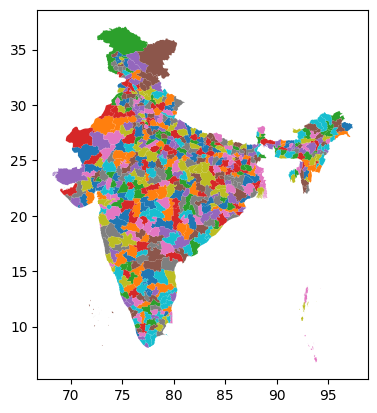

In [11]:
gdf.plot('location')

<Axes: >

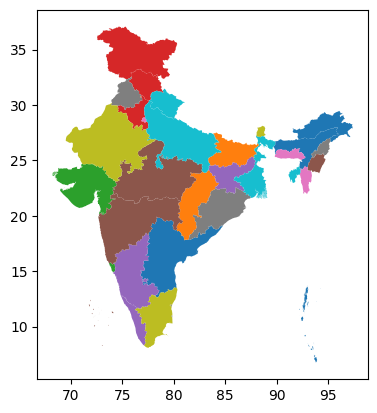

In [12]:
states.plot('ST_NM')

dataframe (csv)

In [13]:
df = pd.read_csv("C:/Users/HOME/OneDrive/Desktop/SIG/GA/2011_crime/dstrIPC_2013.csv")

In [14]:
df.sample(5)

,STATE/UT,DISTRICT,YEAR,MURDER,ATTEMPT TO MURDER,CULPABLE HOMICIDE NOT AMOUNTING TO MURDER,RAPE,CUSTODIAL RAPE,OTHER RAPE,KIDNAPPING & ABDUCTION,...,ARSON,HURT/GREVIOUS HURT,DOWRY DEATHS,ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY,INSULT TO MODESTY OF WOMEN,CRUELTY BY HUSBAND OR HIS RELATIVES,IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES,CAUSING DEATH BY NEGLIGENCE,OTHER IPC CRIMES,TOTAL IPC CRIMES
346,Kerala,PALAKKAD,2013,25,33,13,93,0,93,18,...,27,1296,0,161,19,402,0,2,8246,11848
292,Jharkhand,RAMGARH,2013,25,45,4,36,0,36,40,...,0,257,14,18,9,25,0,113,187,1213
541,Punjab,BATALA,2013,25,23,4,31,0,31,31,...,1,155,1,26,0,35,0,57,229,826
291,Jharkhand,PALAMU,2013,88,64,0,31,0,31,53,...,4,511,22,18,0,31,0,88,679,2228
303,Karnataka,BIDAR,2013,40,47,7,18,0,18,34,...,15,941,7,82,9,112,0,13,2058,3963


fix $state$ column name

In [15]:
df = df.rename({'STATE/UT': 'ST_NM'}, axis=1)

In [17]:
df['ST_NM'] = df['ST_NM'].replace(replaces)

aggregate (sum) crime stats

In [16]:
acts = ['MURDER', 'ATTEMPT TO MURDER',
       'CULPABLE HOMICIDE NOT AMOUNTING TO MURDER', 'RAPE', 'CUSTODIAL RAPE',
       'OTHER RAPE', 'KIDNAPPING & ABDUCTION',
       'KIDNAPPING AND ABDUCTION OF WOMEN AND GIRLS',
       'KIDNAPPING AND ABDUCTION OF OTHERS', 'DACOITY',
       'PREPARATION AND ASSEMBLY FOR DACOITY', 'ROBBERY', 'BURGLARY', 'THEFT',
       'AUTO THEFT', 'OTHER THEFT', 'RIOTS', 'CRIMINAL BREACH OF TRUST',
       'CHEATING', 'COUNTERFIETING', 'ARSON', 'HURT/GREVIOUS HURT',
       'DOWRY DEATHS', 'ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY',
       'INSULT TO MODESTY OF WOMEN', 'CRUELTY BY HUSBAND OR HIS RELATIVES',
       'IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES',
       'CAUSING DEATH BY NEGLIGENCE', 'OTHER IPC CRIMES', 'TOTAL IPC CRIMES']

In [18]:
df['crimes'] = df[acts].sum(axis=1)

In [19]:
df.sample()

,ST_NM,DISTRICT,YEAR,MURDER,ATTEMPT TO MURDER,CULPABLE HOMICIDE NOT AMOUNTING TO MURDER,RAPE,CUSTODIAL RAPE,OTHER RAPE,KIDNAPPING & ABDUCTION,...,HURT/GREVIOUS HURT,DOWRY DEATHS,ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY,INSULT TO MODESTY OF WOMEN,CRUELTY BY HUSBAND OR HIS RELATIVES,IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES,CAUSING DEATH BY NEGLIGENCE,OTHER IPC CRIMES,TOTAL IPC CRIMES,crimes
10,Andhra Pradesh,KARIMNAGAR,2013,101,89,10,57,0,57,118,...,2593,39,354,276,670,0,535,1881,8836,18618


fix $district$ column

In [20]:
df['DISTRICT'] = df['DISTRICT'].astype(str).str.capitalize()

In [21]:
df.sample(5)

,ST_NM,DISTRICT,YEAR,MURDER,ATTEMPT TO MURDER,CULPABLE HOMICIDE NOT AMOUNTING TO MURDER,RAPE,CUSTODIAL RAPE,OTHER RAPE,KIDNAPPING & ABDUCTION,...,HURT/GREVIOUS HURT,DOWRY DEATHS,ASSAULT ON WOMEN WITH INTENT TO OUTRAGE HER MODESTY,INSULT TO MODESTY OF WOMEN,CRUELTY BY HUSBAND OR HIS RELATIVES,IMPORTATION OF GIRLS FROM FOREIGN COUNTRIES,CAUSING DEATH BY NEGLIGENCE,OTHER IPC CRIMES,TOTAL IPC CRIMES,crimes
144,Chhattisgarh,Janjgir,2013,44,27,3,56,0,56,200,...,1248,11,161,11,138,0,181,713,3470,7462
645,Tamil Nadu,Thiruvallur,2013,31,38,1,21,0,21,23,...,392,9,11,0,19,0,325,2449,4003,8278
113,Bihar,Muzaffarpur,2013,208,25,29,43,0,43,382,...,2465,48,5,27,81,2,128,2308,9021,20343
425,Maharashtra,Jalna,2013,57,92,4,35,0,35,31,...,532,50,132,6,351,0,172,539,3173,6904
567,Punjab,Zz total,2013,711,923,104,888,0,888,1274,...,3916,126,1045,67,1741,0,3383,10400,36667,80381


cleaned dataframe $df$ for only district crimes

In [22]:
df = pd.DataFrame(df[['DISTRICT','ST_NM','crimes']])

In [23]:
df['location'] = df['DISTRICT'] + ', ' + df['ST_NM']

In [24]:
df.sample(5)

,DISTRICT,ST_NM,crimes,location
121,Rohtas,Bihar,10381,"Rohtas, Bihar"
493,Longleng,Nagaland,31,"Longleng, Nagaland"
494,Mokokchung,Nagaland,203,"Mokokchung, Nagaland"
265,Samba,Jammu & Kashmir,1595,"Samba, Jammu & Kashmir"
484,Mamit,Mizoram,208,"Mamit, Mizoram"


In [25]:
df.shape

(823, 4)

##### DISTRICTS

merge $gdf$ and $df$ to get district wise crime

In [26]:
d_crimes = gdf.merge(df, on='location', how='inner')

In [27]:
d_crimes.sample(5)

,DISTRICT_x,ST_NM_x,geometry,location,DISTRICT_y,ST_NM_y,crimes
30,Banka,Bihar,"POLYGON ((87.17435 25.04932, 87.17111 25.04644...","Banka, Bihar",Banka,Bihar,4419
212,Kolar,Karnataka,"POLYGON ((77.92568 13.23829, 77.93388 13.25741...","Kolar, Karnataka",Kolar,Karnataka,4767
299,Patiala,Punjab,"MULTIPOLYGON (((76.64044 30.66397, 76.63917 30...","Patiala, Punjab",Patiala,Punjab,6214
154,Hanumangarh,Rajasthan,"POLYGON ((74.04201 29.0097, 74.04213 29.00975,...","Hanumangarh, Rajasthan",Hanumangarh,Rajasthan,10124
368,Sonipat,Haryana,"POLYGON ((76.72974 28.96776, 76.73152 28.97872...","Sonipat, Haryana",Sonipat,Haryana,8013


In [28]:
d_crimes.shape

(426, 7)

remove duplicate columns

In [29]:
d_crimes = d_crimes.drop(['DISTRICT_y','ST_NM_y'], axis=1)

In [30]:
d_crimes = d_crimes.rename({'DISTRICT_x': 'DISTRICT', 'ST_NM_x': 'STATE'}, axis=1)

In [31]:
d_crimes.sample(5)

,DISTRICT,STATE,geometry,location,crimes
268,Nadia,West Bengal,"MULTIPOLYGON (((88.73406 24.06422, 88.73479 24...","Nadia, West Bengal",26034
391,Tumkur,Karnataka,"MULTIPOLYGON (((76.97715 14.05873, 76.9553 14....","Tumkur, Karnataka",10157
141,Gonda,Uttar Pradesh,"POLYGON ((82.07743 27.4106, 82.11632 27.36995,...","Gonda, Uttar Pradesh",5081
355,Sidhi,Madhya Pradesh,"POLYGON ((82.25893 24.59824, 82.27467 24.59337...","Sidhi, Madhya Pradesh",5525
19,Aurangabad,Bihar,"POLYGON ((84.70468 25.04266, 84.70405 25.03777...","Aurangabad, Bihar",7739


check for nulls

In [32]:
pd.isnull(d_crimes['crimes']).sum()

np.int64(0)

see missing districts due to mismatch in records between $gdf$ and $df$

<Axes: >

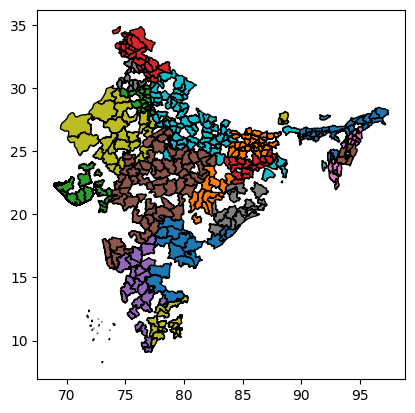

In [ ]:
d_crimes.plot('STATE', edgecolor='k')

general choropleth

<Axes: >

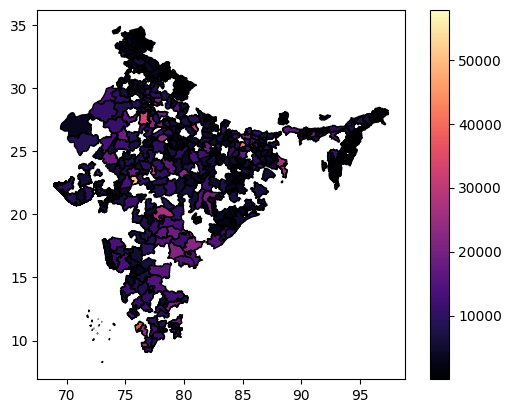

In [41]:
d_crimes.plot(column='crimes', legend=True, cmap='magma', edgecolor='k')

5 classes of crime rates

In [35]:
import mapclassify as mc

<Axes: >

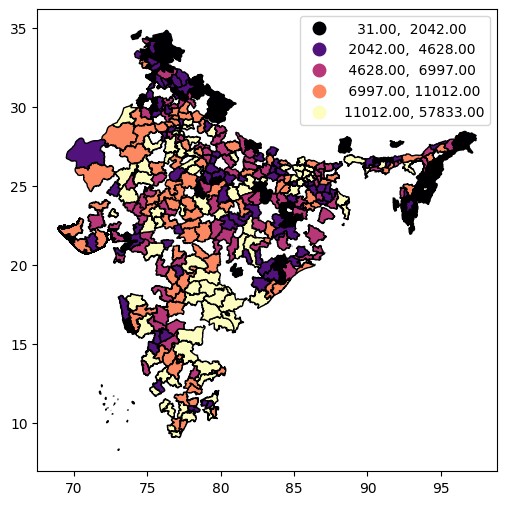

In [40]:
fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'aspect':'equal'})
d_crimes.plot(column='crimes', scheme='Quantiles', k=5, cmap='magma', legend=True, ax=ax, edgecolor='k')

DISTRICT spatial lag

<Axes: >

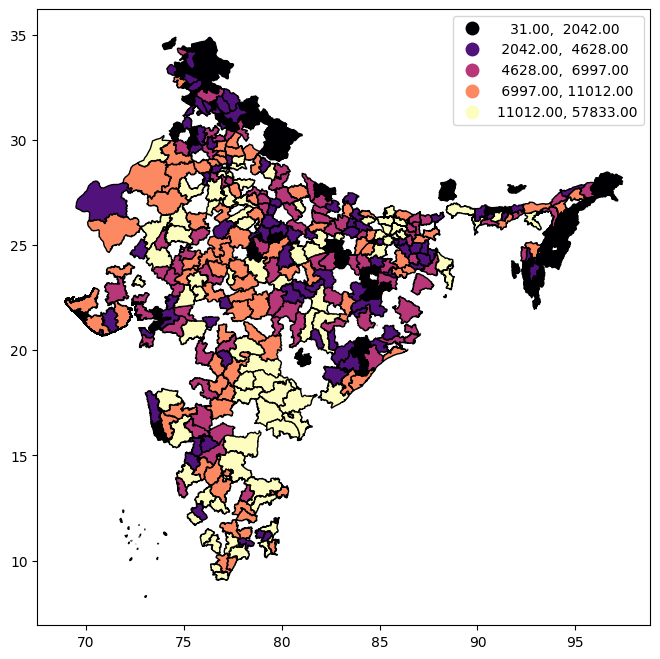

In [44]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
d_crimes.plot(column='crimes', scheme='Quantiles', k=5, cmap='magma', legend=True, ax=ax, edgecolor='k')

In [45]:
wq =  lps.weights.Queen.from_dataframe(d_crimes)
wq.transform = 'r'

C:\Users\HOME\AppData\Local\Temp\ipykernel_7188\3791414074.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(d_crimes)


('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 98, ' is an island (no neighbors)')
('WARNING: ', 130, ' is an island (no neighbors)')
('WARNING: ', 187, ' is an island (no neighbors)')
('WARNING: ', 198, ' is an island (no neighbors)')
('WARNING: ', 215, ' is an island (no neighbors)')
('WARNING: ', 225, ' is an island (no neighbors)')
('WARNING: ', 253, ' is an island (no neighbors)')
('WARNING: ', 278, ' is an island (no neighbors)')
('WARNING: ', 379, ' is an island (no neighbors)')
('WARNING: ', 425, ' is an island (no neighbors)')


c:\Users\HOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 12 islands with ids: 11, 31, 98, 130, 187, 198, 215, 225, 253, 278, 379, 425.
  W.__init__(self, neighbors, ids=ids, **kw)


In [46]:
y = d_crimes['crimes']
ylag = lps.weights.lag_spatial(wq, y)

In [47]:
ylagq5 = mc.Quantiles(ylag, k=5)

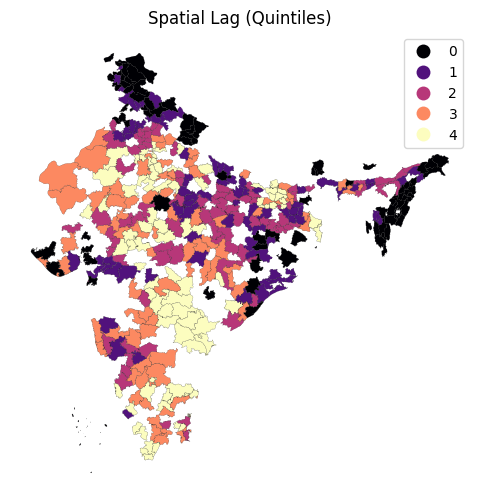

In [49]:
f, ax = plt.subplots(1, figsize=(8, 6))
d_crimes.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='magma', linewidth=0.1, ax=ax, \
        edgecolor='k', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag (Quintiles)")

plt.show()

comparison

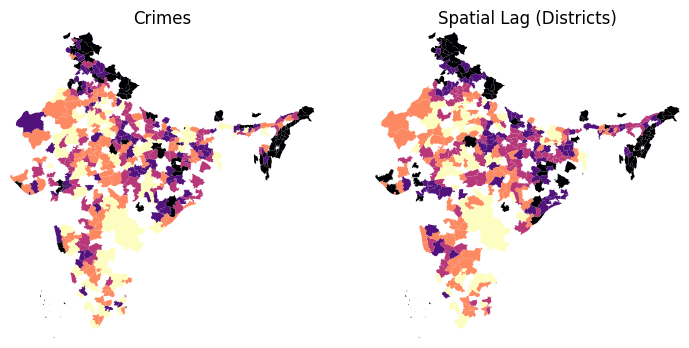

In [50]:
d_crimes['lag'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
d_crimes.plot(column='crimes', ax=ax[0],
        scheme="quantiles",  k=5, cmap='magma')
ax[0].axis(d_crimes.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Crimes")
d_crimes.plot(column='lag', ax=ax[1],
        scheme='quantiles', cmap='magma', k=5)
ax[1].axis(d_crimes.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag (Districts)")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

binary split

In [51]:
print('median crime num: ',y.median())

median crime num:  5722.5


In [ ]:
yb = y > y.median()
sum(yb) # should be half of 400ish

213

In [54]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
d_crimes['yb'] = yb

<Axes: >

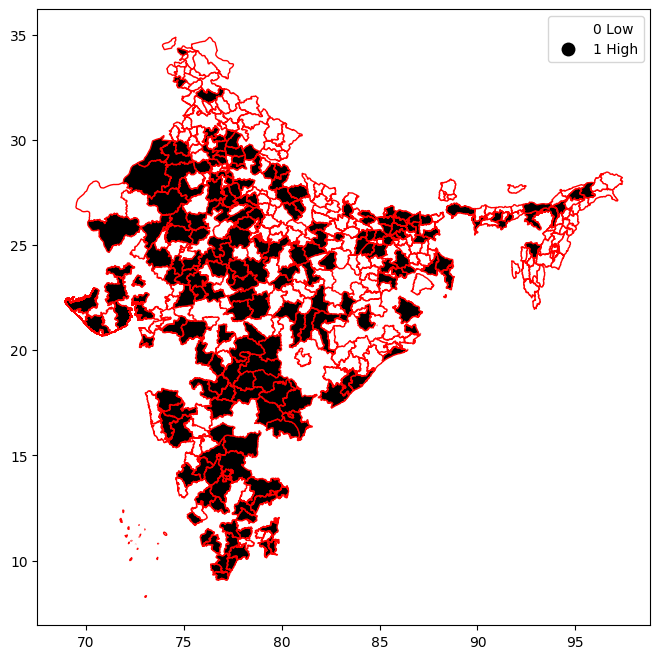

In [56]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
d_crimes.plot(column='yb', cmap='binary', edgecolor='red', legend=True, ax=ax)

#### STATES

In [57]:
s_crime = pd.DataFrame(df)

In [58]:
s_crime = df['crimes'].groupby([df['ST_NM']]).sum()

In [59]:
states.sample(5)

,ST_NM,geometry
1,Andhra Pradesh,"MULTIPOLYGON (((79.99121 13.48456, 79.98596 13..."
19,Maharashtra,"MULTIPOLYGON (((73.45599 16.04706, 73.45622 16..."
11,Haryana,"POLYGON ((76.85956 28.22148, 76.84247 28.21966..."
13,Jammu & Kashmir,"POLYGON ((74.82936 32.48598, 74.82871 32.486, ..."
14,Jharkhand,"POLYGON ((85.96395 22.47954, 85.96515 22.47375..."


In [60]:
s_crime.sample(5)

ST_NM
Punjab              160762
Himachal Pradesh     57840
Tripura              26660
Uttarakhand          43896
Sikkim                3766
Name: crimes, dtype: int64

merge

In [61]:
s_data = states.merge(s_crime, on='ST_NM')

choropleth

<Axes: >

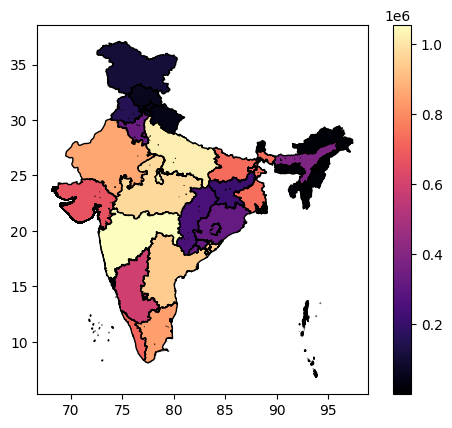

In [62]:
s_data.plot('crimes', cmap='magma', legend=True, edgecolor='k')

5 classes

<Axes: >

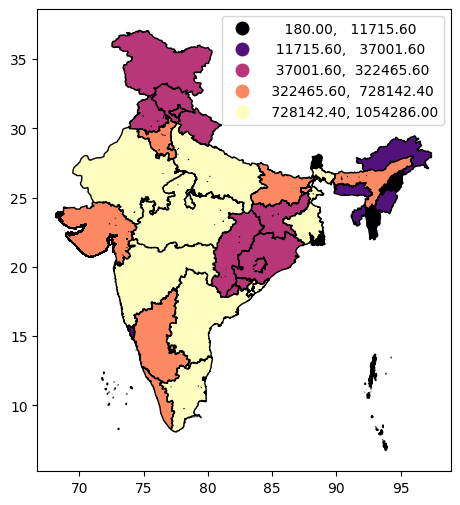

In [63]:
fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'aspect':'equal'})
s_data.plot(column='crimes', scheme='Quantiles', k=5, cmap='magma', legend=True, ax=ax, edgecolor='k')

STATES spatial lag

In [64]:
wq =  lps.weights.Queen.from_dataframe(s_data)
wq.transform = 'r'

C:\Users\HOME\AppData\Local\Temp\ipykernel_7188\689095597.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(s_data)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')


c:\Users\HOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 0, 17.
  W.__init__(self, neighbors, ids=ids, **kw)


In [65]:
y = s_data['crimes']
ylag = lps.weights.lag_spatial(wq, y)
ylagq5 = mc.Quantiles(ylag, k=5)

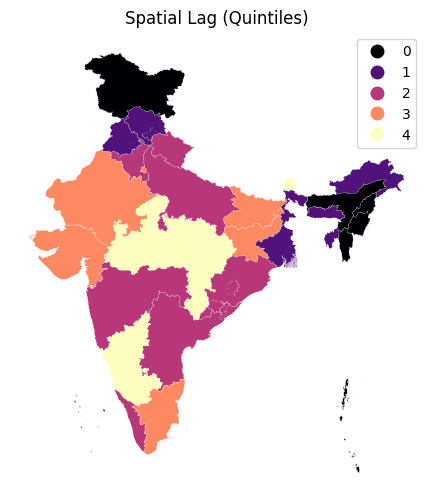

In [67]:
f, ax = plt.subplots(1, figsize=(8, 6))
s_data.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='magma', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag (Quintiles)")

plt.show()

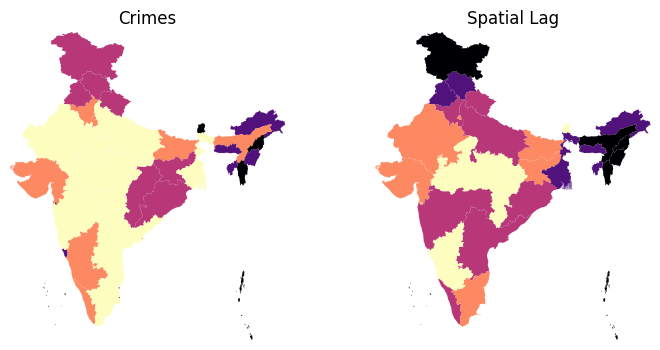

In [68]:
s_data['lag'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
s_data.plot(column='crimes', ax=ax[0],
        scheme="quantiles",  k=5, cmap='magma')
ax[0].axis(s_data.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Crimes")
s_data.plot(column='lag', ax=ax[1],
        scheme='quantiles', cmap='magma', k=5)
ax[1].axis(s_data.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

STATE: binary

In [72]:
print('median crime num: ',y.mean())

median crime num:  329556.22857142857


In [ ]:
yb = y > y.mean()
sum(yb)

14

In [71]:
yb = y > y.mean()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
s_data['yb'] = yb

<Axes: >

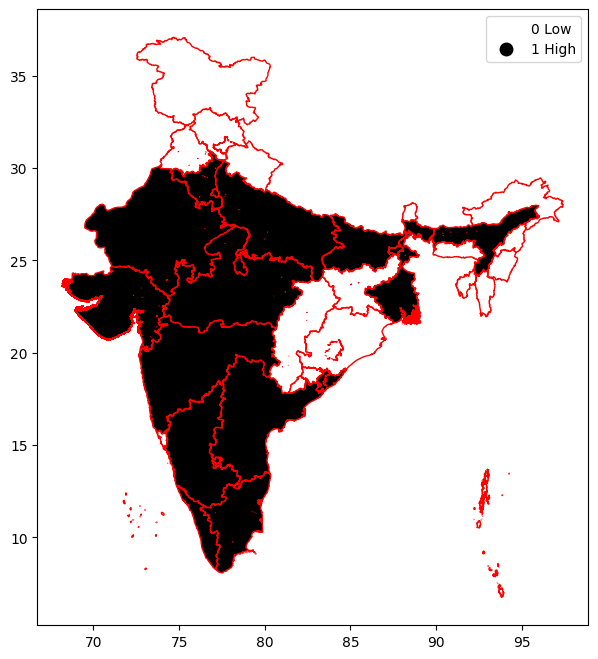

In [73]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
s_data.plot(column='yb', cmap='binary', edgecolor='red', legend=True, ax=ax)